<a href="https://colab.research.google.com/github/LokeshVadlamudi/MachineLearningClass/blob/master/Wildfire_cause_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Wildfire Cause Prediction**

##Team: FourReal

1. Nupur Yadav
2. Chetan Kulkarni
3. Lokesh Vadlamudi
4. Ronak Mehta

##**Problem Definition:**

The number of wildfire cases have drastically increased in the past few years, with more than 52,000 fires in 2018 alone. The goal of this project is to predict the cause of wildfire using meteorological and other weather related data such as location, day of the week, month, temperature and so on. This type of prediction can help government to monitor and mitigate impact of these fires by allocating proper resources based on the cause of fire.

##**Datasets:**

We have taken our base dataset from kaggle (https://www.kaggle.com/rtatman/188-million-us-wildfires) which had 1.88 million historic fires from throughout the United States and during the period of
1992-2015. It had features such as fire cause code (1-13) specifying what started the fire, fire cause description, latitude, and longitude, discovery date etc. 

In our dataset the fire cause code has values from 1-13 mapped to below fire cause description.

1 - Lightning

2 - Equipment Use

3 - Smoking

4 - Campfire

5 - Debris Burning

6 - Railroad

7 - Arson

8 - Children

9 - Miscellaneous

10 - Fireworks

11 - Powerline

12 - Structure

13 - Missing/Undefined

But it didn't have weather related data which was crucial for our prediction so we **amalgamated our base dataset with weather dataset from National Oceanic and Atmospheric Administration (ncdc.novaa.gov website)** and added fields such as Temperature, snow, precipitation, TOBS to our dataset.

##**Importing necessary libraries and loading our base dataset**



In [1]:
#Importing Libraries
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import tree, preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
import random
random.seed( 30 )

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = 'https://drive.google.com/open?id=1ApRYxyMqnFKH8XW1GbQ-KZNJdbdeEdV9'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1ApRYxyMqnFKH8XW1GbQ-KZNJdbdeEdV9


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Fire.csv')

In [6]:
#Loading dataset into pandas dataframe
df = pd.read_csv('Fire.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,36,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#Displaying first few records
df.head()

,Unnamed: 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,NaN,NaN,NaN,NaN,NaN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,13,AAC0,PIGEON,NaN,NaN,NaN,NaN,NaN,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,27,021,A32W,SLACK,NaN,NaN,NaN,NaN,NaN,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,43,6,NaN,DEER,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,44,7,NaN,STEVENOT,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


##**Preprocessing data**

In [8]:
#Checking the columns in dataset
df.columns

Index(['Unnamed: 0', 'OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE',
       'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [9]:
#Displaying the shape of data
df.shape

(1880465, 40)

In [0]:
#Creating a new data frame with required columns
df = df[['FIRE_YEAR','STAT_CAUSE_CODE','STAT_CAUSE_DESCR','LATITUDE','LONGITUDE','STATE','DISCOVERY_DATE','FIRE_SIZE']].copy()

In [11]:
#Checking for the missing values in the dataset
df.isnull().sum()

FIRE_YEAR           0
STAT_CAUSE_CODE     0
STAT_CAUSE_DESCR    0
LATITUDE            0
LONGITUDE           0
STATE               0
DISCOVERY_DATE      0
FIRE_SIZE           0
dtype: int64

As we can see our dataset don't have any missing values.

In [12]:
#Displaying top 5 records
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10


In [13]:
#Converting the DISCOVERY_DATE field's Julian Date format in Gregorian dates
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df.head() #check the data

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28


In [14]:
#Getting some additional data fields such as month and day of the week.
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,2
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,2
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,0
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,0
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,0


Day_OF_Week with Monday=0, Sunday=6.

In [0]:
df_orig=df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE',	'LONGITUDE',	'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE',	'MONTH', 'DAY_OF_WEEK']]

##**Exploratory data analysis**

Doing some exploratory data analysis to see how the features are correlated, what are relevant features for our prediction and if any hidden information we can get to facilitate our prediction.

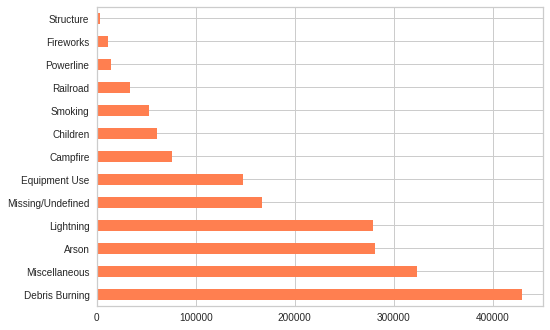

In [16]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

Our dataset has around 13 causes which are too many classes. May be we will try to club these causes to reduce the number of classes and see if this improves our model accuracy.

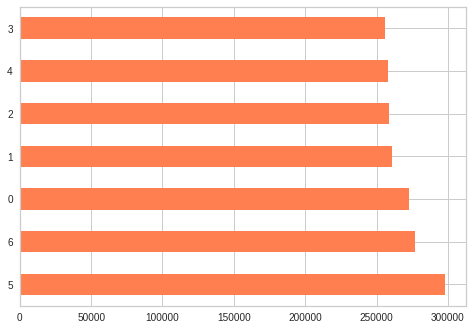

In [17]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

The above graph shows that on weekends (5&6) the fires discovered are slightly more. We are assuming that is because of the people being careless on weekends with campfires or smoking or probably because of some malicious intent. Now, we would like to see how fires are distributed across the weekdays because of the natural causes such as lightning.

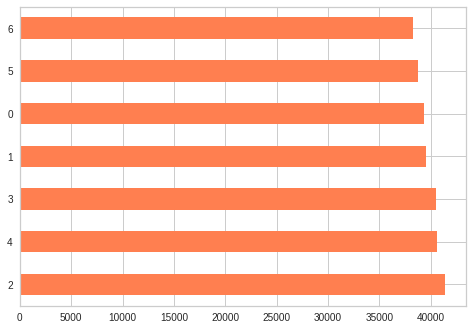

In [18]:
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

As we can see the fires are more on weekdays now and lowered on weekends. I am imagining if the increase on weekends is due to malicious fires such as - Arson. So now we will check the fire distribution on weekdays because of Arson.

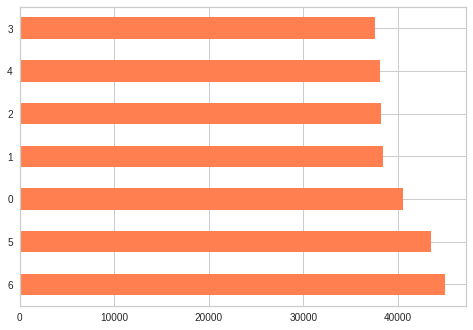

In [19]:
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

The above graph makes it significant that the increase in fire on weekends is because of Arson. We can see probably a 30% increase on weekends than the average of weekdays.

This also proves that Day_Of_Week is an important feature to be kept in our feature set.

###**Performing K-Means Clustering as part of EDA**

We tried clustering based on some selected features to see if we can gain any other insights from our dataset.

In [0]:
#K-means clustering on fire cause and fire size
data = df[['FIRE_SIZE','STAT_CAUSE_CODE']]

####**Using Elbow method to find optimal k**

In [0]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)

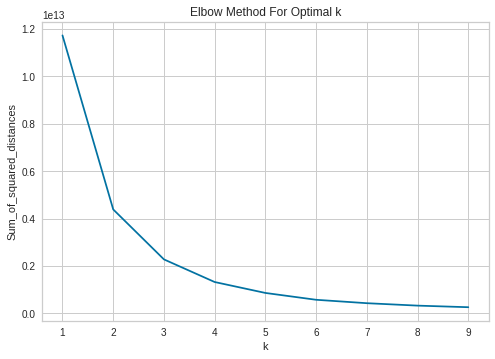

In [22]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We got optimal k as 3.

####**Silhouette score analysis**

In [0]:
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans(random_state=0)
# visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette', timings=False)

# visualizer.fit(data)    
# visualizer.poof() 

From Silhouette score analysis we got that 3 clusters are optimal. Silhoutte score = 0.86

In [0]:
#Applying K-means for optimal k=3
kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(data)

In [25]:
#Adding cluster column to dataset for further analysis
df['cluster'] = y
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK,cluster
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,2,0
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,2,0
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,0,0
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,0,0
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,0,0


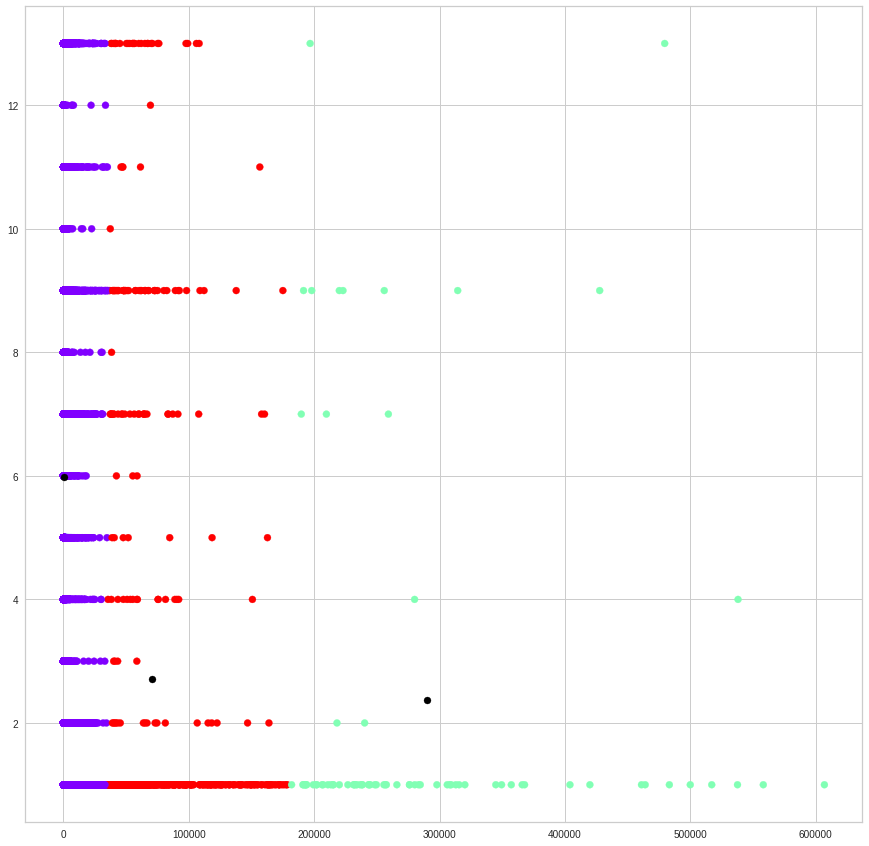

In [26]:
#Plotting the clusters obtained
plt.figure(1,figsize=(15,15))
plt.scatter(df.FIRE_SIZE, df.STAT_CAUSE_CODE, c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

As we can see, the above clusters didn't obtain any meaningful information.

**Performing k-means clustering on latitude and longitude to see the geagraphical coverage of the data**

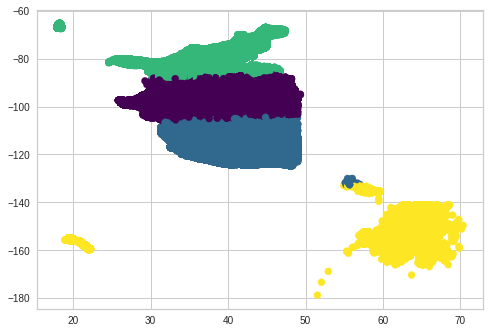

In [27]:
kmeans1 = KMeans(n_clusters=4,random_state=0).fit(df[['LATITUDE','LONGITUDE']])
y_means1 = kmeans1.predict(df[['LATITUDE','LONGITUDE']])
plt.scatter(df['LATITUDE'],df['LONGITUDE'], c=y_means1, s=50, cmap='viridis')

The above plot clearly shows the map of United States and most of the fires have occurred in longitutes between -100 and -120 which is majorly California region.

###**Correlation matrix**

Plotting correlation matrix to get a better understanding of how the features are correlated.

In [28]:
#First converting all features to numeric
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df = df.drop(['cluster'], axis=1)
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,9.0,7,40.036944,-121.005833,4,2453403.5,0.10,2005-02-02,2,2
1,2004,1.0,6,38.933056,-120.404444,4,2453137.5,0.25,2004-05-12,5,2
2,2004,5.0,3,38.984167,-120.735556,4,2453156.5,0.10,2004-05-31,5,0
3,2004,1.0,6,38.559167,-119.913333,4,2453184.5,0.10,2004-06-28,6,0
4,2004,1.0,6,38.559167,-119.933056,4,2453184.5,0.10,2004-06-28,6,0


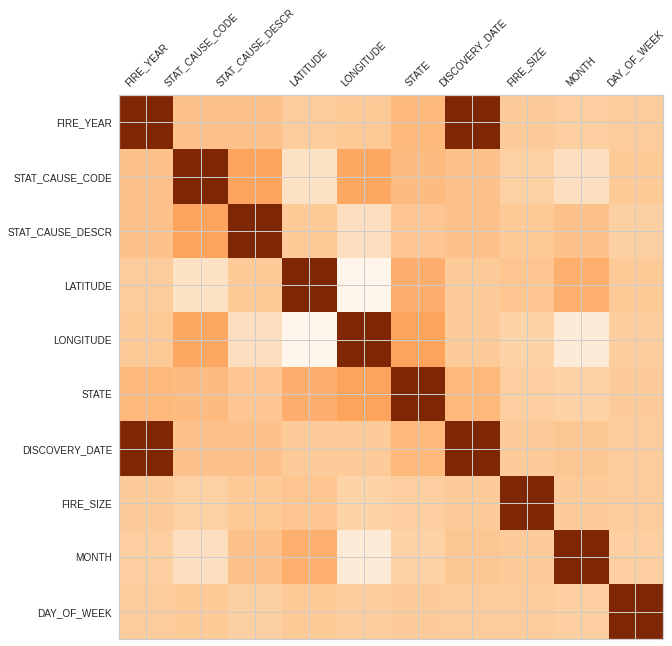

In [29]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(df)

In the above plot darker shades means strong correlation wheras white shade means no correlation. We can see that month is strongly correlated to latitude wheras weakly correlated to longitide.

##**Preparing data for Machine learning**

In [0]:
df = df.drop('DATE',axis=1)
df = df.drop('STAT_CAUSE_CODE', axis=1)
df = df.dropna()

In [31]:
df

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,7,40.036944,-121.005833,4,2453403.5,0.10,2,2
1,2004,6,38.933056,-120.404444,4,2453137.5,0.25,5,2
2,2004,3,38.984167,-120.735556,4,2453156.5,0.10,5,0
3,2004,6,38.559167,-119.913333,4,2453184.5,0.10,6,0
4,2004,6,38.559167,-119.933056,4,2453184.5,0.10,6,0
...,...,...,...,...,...,...,...,...,...
1880460,2015,8,40.481637,-122.389375,4,2457291.5,0.01,9,5
1880461,2015,7,37.617619,-120.938570,4,2457300.5,0.20,10,0
1880462,2015,8,37.617619,-120.938570,4,2457144.5,0.10,5,5
1880463,2015,8,37.672235,-120.898356,4,2457309.5,2.00,10,2


In [0]:
X = df.drop(['STAT_CAUSE_DESCR'], axis=1).values
y = df['STAT_CAUSE_DESCR'].values

In [0]:
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training

####**Applying Random Forest Classifier on base dataset with 13 classes in target variable**

In [34]:
clf_rf = ske.RandomForestClassifier()
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.5833658311766583


In [35]:
lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred = lr.predict(X_test)
log = accuracy_score(y_test,y_pred)*100
print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
print ("Accuracy : ",log) 
print("Report : ",classification_report(y_test, y_pred))

Confusion Matrix:  [[     0      0      0  84170      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  22818      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  18240      0      0      0      0      0      0
       0      0      0]
 [     0      0      0 129099      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  44329      0      0      0      0      0      0
       0      0      0]
 [     0      0      0   3415      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  83316      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  97026      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  50300      0      0      0      0      0      0
       0      0      0]
 [     0      0      0   4289      0      0      0      0      0      0
       0      0      0]
 [     0      0      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00     84170
           1       0.00      0.00      0.00     22818
           2       0.00      0.00      0.00     18240
           3       0.23      1.00      0.37    129099
           4       0.00      0.00      0.00     44329
           5       0.00      0.00      0.00      3415
           6       0.00      0.00      0.00     83316
           7       0.00      0.00      0.00     97026
           8       0.00      0.00      0.00     50300
           9       0.00      0.00      0.00      4289
          10       0.00      0.00      0.00     10053
          11       0.00      0.00      0.00     15925
          12       0.00      0.00      0.00      1160

    accuracy                           0.23    564140
   macro avg       0.02      0.08      0.03    564140
weighted avg       0.05      0.23      0.09    564140



In [36]:
nb = GaussianNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
naive = accuracy_score(y_test,y_pred)*100
print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
print ("Accuracy : ",naive)
print("Report : ",classification_report(y_test, y_pred))

Confusion Matrix:  [[   178      4   2799  75928    266    339   2493   1972    175      0
       6      0     10]
 [     7      3   2429  14263    114   1106   2723   1794    348      0
       2      0     29]
 [     5      0   1344  15072     52    174    902    544    145      0
       1      0      1]
 [    63      3   4203 118599    184    765   1804   2736    719      0
       4      0     19]
 [    50      3   4279  31080    647    384   4830   2950     86      0
       5      0     15]
 [     9      0    202   2291      1    373    451     52     36      0
       0      0      0]
 [   118      0   6703  47155    181   3556  19992   4626    779      0
      12      0    194]
 [    97     11   5535  76715    734   1377   6267   5809    435      0
      17      2     27]
 [   126      8   1837  32991     10    230   1954   3314   9734      0
       0      0     96]
 [     0      3    142   3467     29    121    212    204    108      0
       0      0      3]
 [    17      1    28

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Report :                precision    recall  f1-score   support

           0       0.26      0.00      0.00     84170
           1       0.08      0.00      0.00     22818
           2       0.04      0.07      0.05     18240
           3       0.27      0.92      0.42    129099
           4       0.28      0.01      0.03     44329
           5       0.04      0.11      0.06      3415
           6       0.46      0.24      0.32     83316
           7       0.24      0.06      0.10     97026
           8       0.77      0.19      0.31     50300
           9       0.00      0.00      0.00      4289
          10       0.43      0.00      0.01     10053
          11       0.00      0.00      0.00     15925
          12       0.00      0.00      0.00      1160

    accuracy                           0.28    564140
   macro avg       0.22      0.12      0.10    564140
weighted avg       0.31      0.28      0.19    564140



In [38]:
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
knn = accuracy_score(y_test,y_pred)*100
print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
print ("Accuracy : ",knn) 
print("Report : ",classification_report(y_test, y_pred))

Confusion Matrix:  [[47415  2566  3481 18441  3613   176  2078  5089   892    66   210   136
      7]
 [ 3512  7560  1074  4246  1569   145  2344  1821   381    23    54    87
      2]
 [ 4774  1119  3382  4755  1552   107   732  1391   143    26   166    89
      4]
 [36849  6948  7660 60570  5972   254  2773  6644   650   139   364   263
     13]
 [ 9231  2658  2911 11111 10312   167  2684  4222   425    82   425    96
      5]
 [  518   258   224   465   239  1266   252   144    32     6     3     7
      1]
 [ 4917  4507  1382  5387  3955   433 59392  2295   842    43   105    57
      1]
 [20073  6017  4815 21176  9808   525  6280 26587   971   179   293   295
      7]
 [ 3199  1640   571  2613  1424   127  3847  2278 34563     9    10    19
      0]
 [  731   247   173  1250   526    38   429   646    51   182     6     7
      3]
 [ 1621   526   781  2306  1455    25   702   756    58     9  1796    18
      0]
 [ 3811  1382  1257  4374  1466    57   856  2216   153    33   102 

####**Applying Random Forest Classifier on base dataset with 4 classes in target variable**

In [39]:
def set_label(cat):
    cause = 0
    accidental = ['Lightning','Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']

    if cat in accidental:
        cause = 0
    elif cat in malicious:
        cause = 1
    else:
        cause = 2
    return cause

df['LABEL'] = df_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
df = df.drop('STAT_CAUSE_DESCR',axis=1)
print(df.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  ...  MONTH  DAY_OF_WEEK  LABEL
0       2005  40.036944 -121.005833  ...      2            2      2
1       2004  38.933056 -120.404444  ...      5            2      0
2       2004  38.984167 -120.735556  ...      5            0      0
3       2004  38.559167 -119.913333  ...      6            0      0
4       2004  38.559167 -119.933056  ...      6            0      0

[5 rows x 9 columns]


In [41]:
X = df.drop(['LABEL'], axis=1).values
y = df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
clf_rf = ske.RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.742383096394512


###**Importing amalgamated fire dataset which contains weather related columns such as Temperature, Precipitation, Snow etc. The weatherDataLoad.ipynb file contains the script to fetch data from National Oceanic and Atmospheric Administration (ncdc.novaa.gov website).**

In [42]:
link = 'https://drive.google.com/open?id=1qnqDNrDyxVPBTxE-6BTYDVz-7Iennl_m'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1qnqDNrDyxVPBTxE-6BTYDVz-7Iennl_m


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AmalgamatedFireDataset.csv')

In [0]:
#Loading dataset into pandas dataframe
amal_df = pd.read_csv('AmalgamatedFireDataset.csv')

In [45]:
amal_df.head()

,Unnamed: 0,LATITUDE,LONGITUDE,date,TMAX,PRCP,TOBS,SNOW,STAT_CAUSE_CODE_x,DISCOVERY_DOY_x,FIRE_SIZE_x,FIRE_YEAR,discovery_month,discovery_weekday,STAT_CAUSE_DESCR,STATE,DISCOVERY_DATE
0,0,18.0,-67.0,19970323,292.384615,1.777778,210.153846,0.0,5.0,82.0,1.00,1997.0,Mar,Sun,Debris Burning,PR,2450530.5
1,1,18.0,-67.0,20020210,281.700000,3.258065,201.600000,0.0,9.0,38.0,55.00,2002.0,Feb,Thu,Miscellaneous,PR,2452312.5
2,2,18.0,-67.0,20030315,300.700000,0.714286,212.500000,0.0,8.0,73.0,16.65,2003.0,Mar,Fri,Arson,PR,2452712.5
3,3,18.0,-67.0,20030315,300.700000,0.714286,212.500000,0.0,8.0,73.0,16.65,2003.0,Mar,Fri,Miscellaneous,PR,2452712.5
4,4,18.0,-67.0,20030626,303.545455,1.000000,215.272727,0.0,9.0,175.0,450.00,2003.0,Jun,Tue,Miscellaneous,PR,2452814.5


In [0]:
amal_df=amal_df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE_x', 'discovery_month', 'discovery_weekday', 'TMAX', 'PRCP', 'TOBS', 'SNOW']]

In [0]:
amal_df_orig=amal_df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE_x', 'discovery_month', 'discovery_weekday', 'TMAX', 'PRCP', 'TOBS', 'SNOW']]

In [0]:
amal_df['STAT_CAUSE_DESCR'] = le.fit_transform(amal_df['STAT_CAUSE_DESCR'])
amal_df['STATE'] = le.fit_transform(amal_df['STATE'])
amal_df['discovery_month'] = le.fit_transform(amal_df['discovery_month'])
amal_df['discovery_weekday'] = le.fit_transform(amal_df['discovery_weekday'])

In [49]:
amal_df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE_x,discovery_month,discovery_weekday,TMAX,PRCP,TOBS,SNOW
0,1997.0,3,18.0,-67.0,39,2450530.5,1.00,7,3,292.384615,1.777778,210.153846,0.0
1,2002.0,7,18.0,-67.0,39,2452312.5,55.00,3,4,281.700000,3.258065,201.600000,0.0
2,2003.0,0,18.0,-67.0,39,2452712.5,16.65,7,0,300.700000,0.714286,212.500000,0.0
3,2003.0,7,18.0,-67.0,39,2452712.5,16.65,7,0,300.700000,0.714286,212.500000,0.0
4,2003.0,7,18.0,-67.0,39,2452814.5,450.00,6,5,303.545455,1.000000,215.272727,0.0


In [0]:
amal_X = amal_df.drop(['STAT_CAUSE_DESCR'], axis=1).values
amal_y = amal_df['STAT_CAUSE_DESCR'].values

In [0]:
amal_X_train, amal_X_test, amal_y_train, amal_y_test = train_test_split(amal_X,amal_y,test_size=0.3, random_state=0) #30% for testing, 70% for training

####**Applying Random Forest Classifier on amalgamated dataset with 13 classes in target variable**

In [52]:
amal_clf_rf = ske.RandomForestClassifier(n_estimators=50)
amal_clf_rf = amal_clf_rf.fit(amal_X_train, amal_y_train)
print(amal_clf_rf.score(amal_X_test,amal_y_test))

0.4147628463851342


**XGBoost**

In [56]:
model = XGBClassifier()
model.fit(amal_X_train, amal_y_train)
print(model.score(amal_X_test,amal_y_test))
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.4466397594604112


####**Applying Random Forest Classifier on amalgamated dataset with 4 classes in target variable**

In [53]:
amal_df['LABEL'] = amal_df_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
amal_df = amal_df.drop('STAT_CAUSE_DESCR',axis=1)
print(amal_df.head())

   FIRE_YEAR  LATITUDE  LONGITUDE  STATE  ...      PRCP        TOBS  SNOW  LABEL
0     1997.0      18.0      -67.0     39  ...  1.777778  210.153846   0.0      0
1     2002.0      18.0      -67.0     39  ...  3.258065  201.600000   0.0      2
2     2003.0      18.0      -67.0     39  ...  0.714286  212.500000   0.0      1
3     2003.0      18.0      -67.0     39  ...  0.714286  212.500000   0.0      2
4     2003.0      18.0      -67.0     39  ...  1.000000  215.272727   0.0      2

[5 rows x 13 columns]


In [54]:
X = amal_df.drop(['LABEL'], axis=1).values
y = amal_df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.6393314733049814


**RF with PCA**

In [57]:
dfx = amal_df.drop(['LABEL'], axis=1).values
dfy = amal_df['LABEL'].values
pca_final = PCA(n_components=4)
principalComponents = pca_final.fit_transform(dfx)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4'])
X_train, X_test, y_train, y_test = train_test_split(principalDf, dfy, test_size=0.33)
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.5707038868422608


**XGBoost**

In [55]:
model = XGBClassifier()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.6681041254706503


**KNN**

In [58]:
X = amal_df.drop(['LABEL'], axis=1).values
y = amal_df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
knn = accuracy_score(y_test,y_pred)*100
print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
print ("Accuracy : ",knn) 
print("Report : ",classification_report(y_test, y_pred))


Confusion Matrix:  [[100233   6109   9944]
 [ 18833   3423   3219]
 [ 29720   2970  10134]]
Accuracy :  61.64639596933662
Report :                precision    recall  f1-score   support

           0       0.67      0.86      0.76    116286
           1       0.27      0.13      0.18     25475
           2       0.43      0.24      0.31     42824

    accuracy                           0.62    184585
   macro avg       0.46      0.41      0.41    184585
weighted avg       0.56      0.62      0.57    184585



**PCA KNN**

In [61]:
dfx = amal_df.drop(['LABEL'], axis=1).values
dfy = amal_df['LABEL'].values
pca_final = PCA(n_components=2)
principalComponents = pca_final.fit_transform(dfx)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
X_train, X_test, y_train, y_test = train_test_split(principalDf, dfy, test_size=0.30)
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
knn = accuracy_score(y_test,y_pred)*100
print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
print ("Accuracy : ",knn) 
print("Report : ",classification_report(y_test, y_pred))


Confusion Matrix:  [[99320  6353 11100]
 [19703  2457  2975]
 [34213  2796  5668]]
Accuracy :  58.2089552238806
Report :                precision    recall  f1-score   support

           0       0.65      0.85      0.74    116773
           1       0.21      0.10      0.13     25135
           2       0.29      0.13      0.18     42677

    accuracy                           0.58    184585
   macro avg       0.38      0.36      0.35    184585
weighted avg       0.51      0.58      0.53    184585



In [0]:

df = pd.read_csv('AmalgamatedFireDataset.csv')